# Calculation results 

Via C code a LUT was generated 

```
/**
 * Reflects the lower bits of a value.
 *
 * @param val The value to reflect.
 * @param num_bits The number of lower bits to reflect.
 * @return The reflected value.
 */
uint32_t reflect(uint32_t val, int num_bits)
{
    uint32_t result = 0;
    for (int i = 0; i < num_bits; i++)
    {
        if (val & (1 << i))
            result |= (1 << (num_bits - 1 - i));
    }
    return result;
}

/**
 * Generates a CRC32 lookup table for a given polynomial using reflection.
 *
 * @param crcTable The table to be filled with CRC32 values.
 * @param polynomial The polynomial used for generating the CRC32 values.
 */
void generate_crc32_table(uint32_t crcTable[CRC_TABLE_SIZE], uint32_t polynomial)
{
    polynomial = reflect(polynomial, 32); // Reflect the polynomial
    for (uint32_t i = 0; i < CRC_TABLE_SIZE; i++)
    {
        uint32_t crc = reflect(i, 8); // Reflect the input byte
        for (uint8_t j = 0; j < 8; j++){
            if (crc & 1){
                crc = (crc >> 1) ^ polynomial;
            }else{
                crc >>= 1;
            }
        }
        crcTable[i] = reflect(crc, 32); // Reflect the result before storing it
    }
}
```

## Rcrc

$$ Rcrc(Pe) = \sum_{i=1}^n{A[i] \cdot Pe^i \cdot (1-Pe)^{n-i}}$$


[A_F4ACFB13] Rcrc =  1.571598495047187e-26
[A_F1922815] Rcrc =  1.1839138166552866e-25


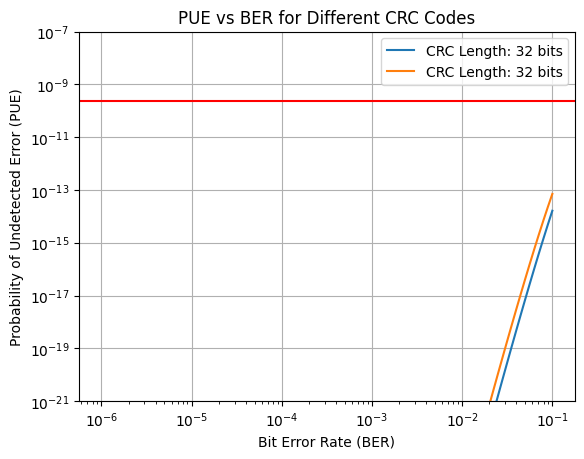

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_single_probability(Pe,i,n,A):
    return (Pe**i)*((1-Pe)**(n-i)) * A[i]


Pe = 0.01 
n = 64

A_F4ACFB13 = np.loadtxt("weight_64bit_F4ACFB13.data")
A_F1922815 = np.loadtxt("weight_64bit_F1922815.data")
assert(A_F4ACFB13.shape[0] == n)
assert(A_F1922815.shape[0] == n)

Rcrc_A_F4ACFB13 = 0.0
Rcrc_A_F1922815 = 0.0
for i in range(1,n):
    p_A_F4ACFB13 = get_single_probability(Pe,i,n,A_F4ACFB13)
    p_A_F1922815 = get_single_probability(Pe,i,n,A_F1922815)
    Rcrc_A_F4ACFB13 += p_A_F4ACFB13 
    Rcrc_A_F1922815 += p_A_F1922815

print("[A_F4ACFB13] Rcrc = ", Rcrc_A_F4ACFB13)
print("[A_F1922815] Rcrc = ", Rcrc_A_F1922815)


Rcrc_list_F4ACFB13 = []
Rcrc_list_F1922815 = []
min_pe=1e-6
max_pe=0.1
ber_range = (min_pe, max_pe)
Pe_list = np.logspace(np.log10(ber_range[0]), np.log10(ber_range[1]), num=100)

for e in Pe_list:
    Rcrc_F4ACFB13_ = 0.0
    Rcrc_F1922815_ = 0.0
    for i in range(1,n):
        p_F4ACFB13 = get_single_probability(e,i,n,A_F4ACFB13)
        p_F1922815 = get_single_probability(e,i,n,A_F1922815)
        Rcrc_F4ACFB13_ += p_F4ACFB13 
        Rcrc_F1922815_ += p_F1922815

    Rcrc_list_F4ACFB13.append(Rcrc_F4ACFB13_)
    Rcrc_list_F1922815.append(Rcrc_F1922815_)

#print(Pe_list)
#print(Rcrc_list)

fig, ax = plt.subplots(1,1) #plt.figure(figsize=(10, 6))
#ax.semilogx(ber_values, pue_values, label=f'CRC Length: {crc_length} bits, Hamming Distance: {hamming_distance}')
plt.loglog(Pe_list, Rcrc_list_F4ACFB13, label=f'CRC Length: 32 bits')
plt.loglog(Pe_list, Rcrc_list_F1922815, label=f'CRC Length: 32 bits')
plt.axhline(1/(2**32), color='r')  # Add horizontal line worst case
ax.set_ylim(1e-21,1e-7)
plt.xlabel('Bit Error Rate (BER)')
plt.ylabel('Probability of Undetected Error (PUE)')
plt.title('PUE vs BER for Different CRC Codes')
plt.legend()
plt.grid(True)


